In [129]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import calendar
from datetime import datetime,timedelta

import os 
import scipy.stats as sps
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

os.chdir("E:/200_CASA/07_QM/QM_CW2")
os.getcwd()

pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('science') # specifies that graphs should use ggplot styling
plt1 = "coolwarm"

# Read Data

In [20]:
df_train = pd.read_csv("data/train.csv").convert_dtypes()
df_test = pd.read_csv("data/test.csv").convert_dtypes()

In [24]:
df = df_train.append(df_test).reset_index(drop=True)

In [25]:
df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.8400,14.3950,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.0200,13.6350,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.0200,13.6350,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.8400,14.3950,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.8400,14.3950,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
17374,2012-12-31 19:00:00,1,0,1,2,10.6600,12.8800,60,11.0014,<NA>,<NA>,<NA>
17375,2012-12-31 20:00:00,1,0,1,2,10.6600,12.8800,60,11.0014,<NA>,<NA>,<NA>
17376,2012-12-31 21:00:00,1,0,1,1,10.6600,12.8800,60,11.0014,<NA>,<NA>,<NA>
17377,2012-12-31 22:00:00,1,0,1,1,10.6600,13.6350,56,8.9981,<NA>,<NA>,<NA>


原始数据需要预测，每个月后十天数据缺失
* 更换数据 https://www.kaggle.com/hmavrodiev/london-bike-sharing-dataset?select=london_merged.csv

In [2]:
df = pd.read_csv("data/london_merged.csv").convert_dtypes()

In [3]:
dfc = df.copy()

* "timestamp" - timestamp field for grouping the data 
* "cnt" - the count of a new bike shares 
* "t1" - real temperature in C 
* "t2" - temperature in C "feels like" 
* "hum" - humidity in percentage 
* "windspeed" - wind speed in km/h 
* "weathercode" - category of the weather 
    * 1 = Clear ; mostly clear but have some values with haze/fog/patches of fog/ fog in vicinity 
    * 2 = scattered clouds / few clouds 
    * 3 = Broken clouds 
    * 4 = Cloudy 
    * 7 = Rain/ light Rain shower/ Light rain 
    * 10 = rain with thunderstorm 
    * 26 = snowfall 
    * 94 = Freezing Fog
* "isholiday" - boolean field - 1 holiday / 0 non holiday
* "isweekend" - boolean field - 1 if the day is weekend
* "season" - category field meteorological seasons: 0-spring ; 1-summer; 2-fall; 3-winter.

In [4]:
dfc

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0000,2.0000,93.0000,6.0000,3,0,1,3
1,2015-01-04 01:00:00,138,3.0000,2.5000,93.0000,5.0000,1,0,1,3
2,2015-01-04 02:00:00,134,2.5000,2.5000,96.5000,0.0000,1,0,1,3
3,2015-01-04 03:00:00,72,2.0000,2.0000,100.0000,0.0000,1,0,1,3
4,2015-01-04 04:00:00,47,2.0000,0.0000,93.0000,6.5000,1,0,1,3
...,...,...,...,...,...,...,...,...,...,...
17409,2017-01-03 19:00:00,1042,5.0000,1.0000,81.0000,19.0000,3,0,0,3
17410,2017-01-03 20:00:00,541,5.0000,1.0000,81.0000,21.0000,4,0,0,3
17411,2017-01-03 21:00:00,337,5.5000,1.5000,78.5000,24.0000,4,0,0,3
17412,2017-01-03 22:00:00,224,5.5000,1.5000,76.0000,23.0000,4,0,0,3


# Feature Engineering 

* 根据时间列创建新的列"date, hour, month, weekday"
* 将"season, is_holiday, is_weekend, weather"的数据类型转变为 category。
* 删除时间列，因为我们已经从中提取了有用的特性。

In [5]:
dfc.timestamp

0        2015-01-04 00:00:00
1        2015-01-04 01:00:00
2        2015-01-04 02:00:00
3        2015-01-04 03:00:00
4        2015-01-04 04:00:00
                ...         
17409    2017-01-03 19:00:00
17410    2017-01-03 20:00:00
17411    2017-01-03 21:00:00
17412    2017-01-03 22:00:00
17413    2017-01-03 23:00:00
Name: timestamp, Length: 17414, dtype: string

## Creating New Columns From "Datetime" Column

In [6]:
# Creating New Columns From "Datetime" Column
dfc["date"] = dfc.timestamp.apply(lambda x : x.split()[0])
dfc["hour"] = dfc.timestamp.apply(lambda x : x.split()[1].split(":")[0])
dfc["weekday"] = dfc.date.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()])
dfc["month"] = dfc.date.apply(lambda dateString : calendar.month_name[datetime.strptime(dateString,"%Y-%m-%d").month])
dfc["season"] = dfc.season.map({0: "Spring", 1 : "Summer", 2 : "Fall", 3:"Winter" })
dfc["weather"] = dfc.weather_code.map({1:"Clear ; mostly clear but have some values with haze/fog/patches of fog/ fog in vicinity",
                                       2:"scattered clouds / few clouds",
                                       3:"Broken clouds",
                                       4:"Cloudy",
                                       7:"Rain/ light Rain shower/ Light rain",
                                       10:"rain with thunderstorm",
                                       26:"snowfall",
                                       94:"Freezing Fog"})
dfc["holiday"] = dfc.is_holiday.map({0:"Not holiday",1:"Holiday"})
dfc["weekend"] = dfc.is_weekend.map({0:"Weekday",1:"Weekend"})

## Coercing To Category Type

In [7]:
# Coercing To Category Type
categoryVariableList = ["weekday","month","season","weather","holiday","weekend"]
for var in categoryVariableList:
    dfc[var] = dfc[var].astype("category")

## Dropping Unncessary Columns

In [8]:
dfc  = dfc.drop(["timestamp","weather_code","is_holiday","is_weekend"],axis=1)

## Dtypes

[Text(0.5, 0, 'variableTypeariable Type'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Variables DataType Count')]

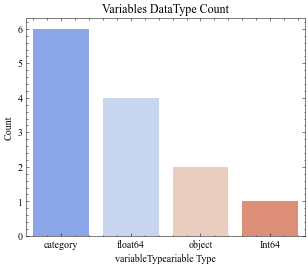

In [9]:
dataTypeDf = pd.DataFrame(dfc.dtypes.astype(str).value_counts()).reset_index().rename(columns={"index":"variableType",0:"count"})
fig,ax = plt.subplots()
fig.set_size_inches(5,4)
sns.barplot(x=dataTypeDf.variableType.values,
           y=dataTypeDf["count"].values,ax=ax,palette=plt1)
ax.set(xlabel='variableTypeariable Type', ylabel='Count',title="Variables DataType Count")

In [10]:
dfc["date"] = dfc["date"].astype("datetime64")

In [11]:
dfx = dfc[["cnt","t1","t2","hum","wind_speed","weather","season","month","weekend","holiday","weekday","date","hour"]]

In [12]:
dfx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   cnt         17414 non-null  Int64         
 1   t1          17414 non-null  float64       
 2   t2          17414 non-null  float64       
 3   hum         17414 non-null  float64       
 4   wind_speed  17414 non-null  float64       
 5   weather     17414 non-null  category      
 6   season      17414 non-null  category      
 7   month       17414 non-null  category      
 8   weekend     17414 non-null  category      
 9   holiday     17414 non-null  category      
 10  weekday     17414 non-null  category      
 11  date        17414 non-null  datetime64[ns]
 12  hour        17414 non-null  object        
dtypes: Int64(1), category(6), datetime64[ns](1), float64(4), object(1)
memory usage: 1.0+ MB


## Missing values

time stamp from 2015-01-04 00:00:00 to 2017-01-03 23:00:00
2016闰年，共计17544小时

In [13]:
365*24*2+24  

17544

In [14]:
dt1 = datetime(2015, 1, 4,0,0,0)
td = timedelta(hours=1)
delta = set(pd.Series([(dt1+ td*i).strftime("%Y-%m-%d %H:%M:%S") for i in range(17544)]))-set(df.timestamp)

数据缺失比例

In [15]:
print(f"{len(delta)/17544 *100:.3f}%")

0.741%


<AxesSubplot:>

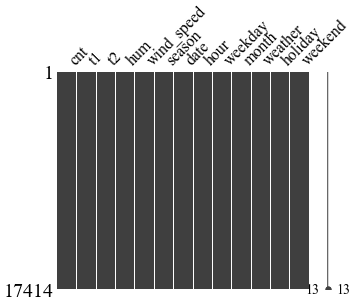

In [16]:
import missingno as msno
msno.matrix(dfc,figsize=(5,4))

* 变量类型： cnt, 天气情况，时间
* 数据类型： Nominal, Ordinal, Interval, Ratio 
* 缺失值比例

# Data summary

In [17]:
dfx.shape

(17414, 13)

## outliers and distribution analysis

* descriptive statistics

In [20]:
dfx.describe()

,cnt,t1,t2,hum,wind_speed
count,"17,414.0000","17,414.0000","17,414.0000","17,414.0000","17,414.0000"
mean,"1,143.1016",12.4681,11.5208,72.3250,15.9131
std,"1,085.1081",5.5718,6.6151,14.3132,7.8946
min,0.0000,-1.5000,-6.0000,20.5000,0.0000
25%,257.0000,8.0000,6.0000,63.0000,10.0000
50%,844.0000,12.5000,12.5000,74.5000,15.0000
75%,"1,671.7500",16.0000,16.0000,83.0000,20.5000
max,"7,860.0000",34.0000,34.0000,100.0000,56.5000


### count

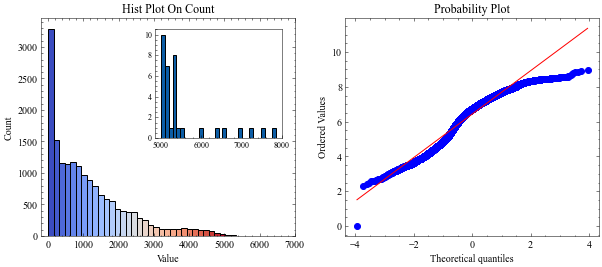

In [147]:
fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(10,4))

hist, edges = np.histogram(dfx["cnt"],bins=50)
norm = plt.Normalize(edges.min(), edges.max()-3000)
colors = plt.cm.coolwarm(norm(edges).astype(float))
ax[0].bar(edges[:-1], hist,np.diff(edges), color=colors, ec="k", align="edge")
ax[0].set(xlabel="Value",ylabel='Count',title="Hist Plot On Count",xlim=[-200,7000])

ax1x = ax[0].inset_axes([0.45, 0.45, 0.5, 0.5])
#ax1x.set_ylabel("count",size=9)
ax1x.hist(dfx[dfx["cnt"]>5000]["cnt"],bins=30,ec="k")
ax1x.tick_params(axis=u'both',which=u'both',labelright=0,labelleft =1,labelbottom=1,bottom=1,top=0,right=0,labelsize=8)

sps.probplot(np.log1p(dfx["cnt"]),dist='norm',fit=True, plot=ax[1])

fig.savefig("counthistplot.png",dpi=300)

In [56]:
dfx[dfx["cnt"]>6000]

,cnt,t1,t2,hum,wind_speed,weather,season,month,weekend,holiday,weekday,date,hour
4461,7531,14.5000,14.5000,61.0000,19.0000,scattered clouds / few clouds,Summer,July,Weekday,Not holiday,Thursday,2015-07-09,08
4469,6033,23.0000,22.0000,26.0000,11.0000,Clear ; mostly clear but have some values with...,Summer,July,Weekday,Not holiday,Thursday,2015-07-09,16
4470,7860,23.0000,22.0000,27.0000,11.0000,Clear ; mostly clear but have some values with...,Summer,July,Weekday,Not holiday,Thursday,2015-07-09,17
4471,6913,22.5000,21.5000,29.0000,13.0000,Clear ; mostly clear but have some values with...,Summer,July,Weekday,Not holiday,Thursday,2015-07-09,18
5129,6585,19.0000,19.0000,78.0000,12.0000,Rain/ light Rain shower/ Light rain,Summer,August,Weekday,Not holiday,Thursday,2015-08-06,08
5138,7208,22.5000,22.5000,55.0000,17.5000,scattered clouds / few clouds,Summer,August,Weekday,Not holiday,Thursday,2015-08-06,17
5139,6394,21.5000,21.5000,58.5000,20.0000,scattered clouds / few clouds,Summer,August,Weekday,Not holiday,Thursday,2015-08-06,18


* 伦敦大规模罢工 
    * 2015-07-09 http://www.chinadaily.com.cn/world/2015-07/09/content_21239501.htm
    * 2015-08-06 
* 峰值出现在早晚高峰，对工作日的模式影响不大，不剔除
* todo：这两天的时序

### t1 t2

In [68]:
df['t1'].mode()[0]

13.0

D:\Miniconda\envs\sds20\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\Miniconda\envs\sds20\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


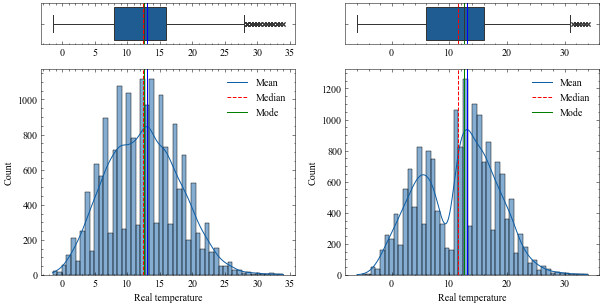

In [92]:
f, ax = plt.subplots(2,2,figsize=(10,5),gridspec_kw= {"height_ratios": (0.2, 1)})
(ax1_box, ax2_box, ax1_hist, ax2_hist) = ax.flatten()
mean=df['t1'].mean()
median=df['t1'].median()
mode=df['t1'].mode()[0]

sns.boxplot(df["t1"], ax=ax1_box,flierprops = dict(marker='x', markersize=4))
ax1_box.axvline(mean, color='r', linestyle='--')
ax1_box.axvline(median, color='g', linestyle='-')
ax1_box.axvline(mode, color='b', linestyle='-')
ax1_box.set(xlabel='')

sns.histplot(dfx["t1"],bins=50,ec="k",ax=ax1_hist,kde=True)
ax1_hist.axvline(mean, color='r', linestyle='--')
ax1_hist.axvline(median, color='g', linestyle='-')
ax1_hist.axvline(mode, color='b', linestyle='-')
ax1_hist.legend({'Mean':mean,'Median':median,'Mode':mode})
ax1_hist.set(xlabel='Real temperature')

mean=df['t2'].mean()
median=df['t2'].median()
mode=df['t2'].mode()[0]

sns.boxplot(df["t2"], ax=ax2_box,flierprops = dict(marker='x', markersize=4))
ax2_box.axvline(mean, color='r', linestyle='--')
ax2_box.axvline(median, color='g', linestyle='-')
ax2_box.axvline(mode, color='b', linestyle='-')
ax2_box.set(xlabel='')

sns.histplot(dfx["t2"],bins=50,ec="k",ax=ax2_hist,kde=True)
ax2_hist.axvline(mean, color='r', linestyle='--')
ax2_hist.axvline(median, color='g', linestyle='-')
ax2_hist.axvline(mode, color='b', linestyle='-')
ax2_hist.legend({'Mean':mean,'Median':median,'Mode':mode})
ax2_hist.set(xlabel='Real temperature')

f.savefig("t1t1hist.png",dpi=300)

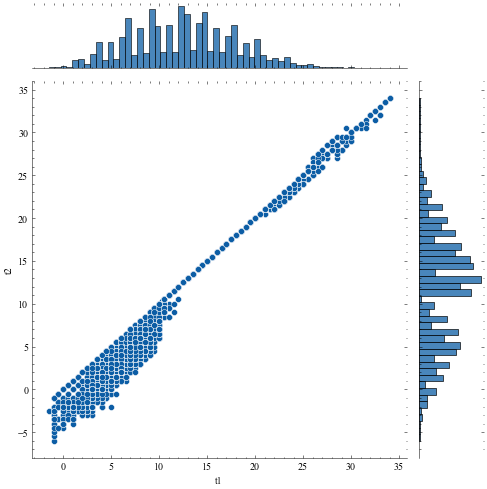

In [89]:
g = sns.jointplot(x="t1", y="t2", data=dfx,height=7)

## agg

In [98]:
dfx.groupby("season").agg({"mean"})

,cnt,t1,t2,hum,wind_speed
,mean,mean,mean,mean,mean
season,,,,,
Fall,"1,178.9542",13.0392,12.5083,76.0959,14.3304
Spring,"1,103.8316",10.6667,9.4231,68.5983,16.3955
Summer,"1,464.4652",18.4312,18.3880,66.8451,15.7838
Winter,821.7291,7.6870,5.7107,77.9113,17.1273


In [102]:
dfx.groupby("month").agg({"mean"})

,cnt,t1,t2,hum,wind_speed
,mean,mean,mean,mean,mean
month,,,,,
April,"1,112.9534",10.2069,8.9159,67.5323,15.3376
August,"1,463.1166",19.2247,19.2069,67.2894,14.9505
December,845.5162,10.0863,9.1543,81.0323,16.6233
February,836.2796,6.1935,3.6063,74.9058,16.8742
January,784.6920,6.6574,4.1974,77.5434,17.8615
July,"1,543.6962",19.2937,19.2529,64.3835,16.8224
June,"1,383.3544",16.7046,16.6326,68.9451,15.5717
March,921.2950,7.7912,5.6151,71.9038,16.8367


In [103]:
dfx.groupby("weekday").agg({"mean"})

,cnt,t1,t2,hum,wind_speed
,mean,mean,mean,mean,mean
weekday,,,,,
Friday,"1,182.7727",12.4296,11.4690,72.3518,15.3663
Monday,"1,130.2707",12.3244,11.4079,73.1435,15.6720
Saturday,995.5538,12.5680,11.5538,72.6826,16.4552
Sunday,959.5673,12.2764,11.3117,73.2356,15.6641
Thursday,"1,258.8106",12.5576,11.5845,71.1256,16.0989
Tuesday,"1,230.1054",12.4774,11.5984,71.9395,15.9277
Wednesday,"1,244.4090",12.6458,11.7218,71.7917,16.2069


In [112]:
dfx.groupby("hour").agg({"mean"})

,cnt,t1,t2,hum,wind_speed
,mean,mean,mean,mean,mean
hour,,,,,
00,290.6091,11.2396,10.2390,78.1385,13.9541
01,200.6312,10.9763,9.9418,79.3018,13.6779
02,136.3037,10.7413,9.6630,80.3037,13.3856
03,94.2455,10.5319,9.4431,81.0777,13.1026
04,73.3135,10.3571,9.2365,81.6706,12.9598
05,110.7074,10.2531,9.1463,82.1061,12.9209
06,466.6267,10.3402,9.2080,81.5971,13.3905
07,"1,468.7452",10.7348,9.6054,80.0090,13.9752


[Text(0.5, 0, 'Hour Of The Day'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Box Plot On Count Across Hour Of The Day')]

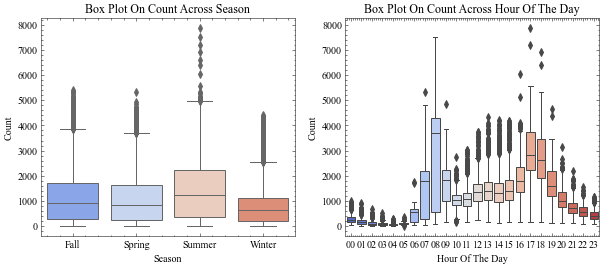

In [115]:
fig, axes = plt.subplots(nrows=1,ncols=2)
fig.set_size_inches(10, 4)

sns.boxplot(data=dfc,y="cnt",x="season",palette = plt1,ax=axes[0])
sns.boxplot(data=dfc,y="cnt",x="hour",orient="v",palette = plt1,ax=axes[1])

axes[0].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Season")
axes[1].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")


* 春季的计数相对较低。箱线图中值的下降就是证据。
* 带有“每日一小时”的箱线图非常有趣。上午7 - 8点和下午5 - 6点的中值相对较高。这可以归因于当时学校和办公室的普通用户。
* 大部分的离群点主要来源于“工作日”而不是“非工作日”。从图4可以很清楚地看到它。

# Correlation analysis

绘制"count,t1,t2,hum,windspeed"之间的相关矩阵

* 温度和湿度特征与cnt呈正相关和负相关。虽然它们之间的相关性不是很明显，但cnt对“温度”和“湿度”的依赖性很小。
* 风速并不是真正有用的数字特征
* 由于“t1”与“t2”之间具有很强的相关性，故不考虑“t2”变量。共线性

回归图描述这两个特征之间关系，考虑 count vs t1,hum,风速

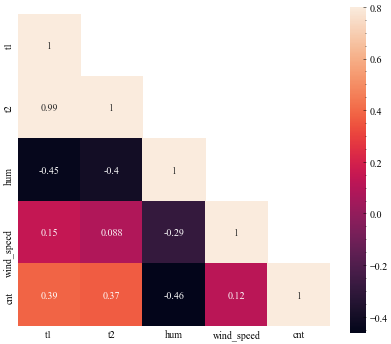

In [125]:
corrMatt = dfc[["t1","t2","hum","wind_speed","weather","cnt"]].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(7,6)
sns.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)
ax.tick_params(axis=u'both',which=u'both',labelright=0,labelleft =1,labelbottom=1,top=0,right=0,left=0,bottom=0,labelsize=10)
fig.savefig("corr.png",dpi=300)

In [126]:
dfc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   cnt         17414 non-null  Int64         
 1   t1          17414 non-null  float64       
 2   t2          17414 non-null  float64       
 3   hum         17414 non-null  float64       
 4   wind_speed  17414 non-null  float64       
 5   season      17414 non-null  category      
 6   date        17414 non-null  datetime64[ns]
 7   hour        17414 non-null  object        
 8   weekday     17414 non-null  category      
 9   month       17414 non-null  category      
 10  weather     17414 non-null  category      
 11  holiday     17414 non-null  category      
 12  weekend     17414 non-null  category      
dtypes: Int64(1), category(6), datetime64[ns](1), float64(4), object(1)
memory usage: 1.0+ MB


<AxesSubplot:xlabel='hum', ylabel='cnt'>

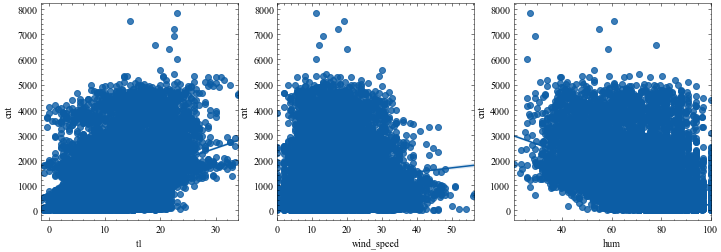

In [183]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 4)
sns.regplot(x=dfc["t1"].astype(float), y=dfc["cnt"].astype(int), ax=ax1)
sns.regplot(x=dfc["wind_speed"].astype(float), y=dfc["cnt"].astype(int),ax=ax2)
sns.regplot(x=dfc["hum"].astype(float), y=dfc["cnt"].astype(int),ax=ax3)

# Clustering

* 对24小时使用dbscan
* 讨论聚类与分类变量的关系

# Regression

In [ ]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings

In [160]:

def transform_for_regression(df,y,dicx):
    '''
    pick and transform data columns from the given dataframe df
    
    y: dependent variable
    dicx: independent variables
    '''
    dft = pd.DataFrame()
    
    variables = y["var"]
    if y["method"] == "log":
        dft["y"] = df.apply(lambda x : np.log(x[variables]), axis=1)
        
    ## x 
    if len(dicx["source"]) != 0:
        for k,v in dicx["source"].items():
            dft[k] = df[v]

    if len(dicx["category"]) != 0:
        for k,v in dicx["category"].items():
            dft[k] = df[v].astype("category")
            dft = pd.get_dummies(dft)

    return dft
def drop_column_using_vif_(df, thresh=40):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: the max VIF value before the feature is removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print(f'Dropping: {index_to_drop}\n VIF_value:{vif_df.VIF.max()}')
            print("=="*20)
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [171]:
dfx = dfx.iloc[np.where(dfx.cnt>0)[0],:]

In [172]:
y = {"method":"log","var" : "cnt"}

dicx = {}
dicx["source"]  = {'t1':'t1', 'hum':'hum', 'wind_speed':'wind_speed'}
dicx["category"] ={'wth':"weather"}

print(f"variables:{dicx},\ny:{y}")

dft = transform_for_regression(dfx,y,dicx)

variables:{'source': {'t1': 't1', 'hum': 'hum', 'wind_speed': 'wind_speed'}, 'category': {'wth': 'weather'}},
y:{'method': 'log', 'var': 'cnt'}


In [173]:
print("++"*60)

## drop
dft_selected = drop_column_using_vif_(dft.drop('y', axis=1),5)
print(dft_selected.columns)
print("++"*60)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Dropping: wth_Broken clouds
 VIF_value:inf


D:\Miniconda\envs\sds20\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
D:\Miniconda\envs\sds20\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Index(['t1', 'hum', 'wind_speed',
       'wth_Clear ; mostly clear but have some values with haze/fog/patches of fog/ fog in vicinity',
       'wth_Cloudy', 'wth_Rain/ light Rain shower/ Light rain',
       'wth_rain with thunderstorm', 'wth_scattered clouds / few clouds',
       'wth_snowfall'],
      dtype='object')
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.974
Model:                            OLS   Adj. R-squared (uncentered):              0.974
Method:                 Least Squares   F-statistic:                          6.416e+04
Date:                Fri, 11 Dec 2020   Prob (F-statistic):                        0.00
Time:                        09:37:43   Log-Likelihood:                         -25829.
No. Observations:               17413   AIC:                                  5.168e+04
Df Residuals:                   17403   BIC:                                  5.176e+04
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                                                                                                  coef    std err       

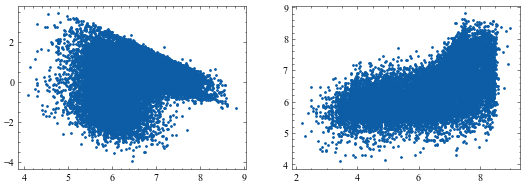

In [181]:
model = sm.OLS(endog=dft[["y"]], exog=sm.add_constant(dft_selected),hasconst=False).fit()
print(model.summary())

## residual
print("++"*60)
fig, ax = plt.subplots(1,2,figsize=(9,3))
ax[0].scatter(model.fittedvalues, model.resid,s=3)
ax[1].scatter(dft["y"],model.fittedvalues,s=3)

(array([  28.,  282.,  969., 1608., 1532., 1944., 3569., 4288., 2671.,
         522.]),
 array([2.19722458, 2.87445631, 3.55168804, 4.22891977, 4.9061515 ,
        5.58338323, 6.26061496, 6.93784669, 7.61507842, 8.29231015,
        8.96954189]),
 <BarContainer object of 10 artists>)

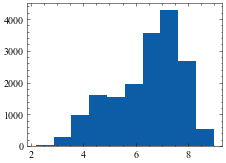

In [176]:
plt.hist(dft[["y"]])

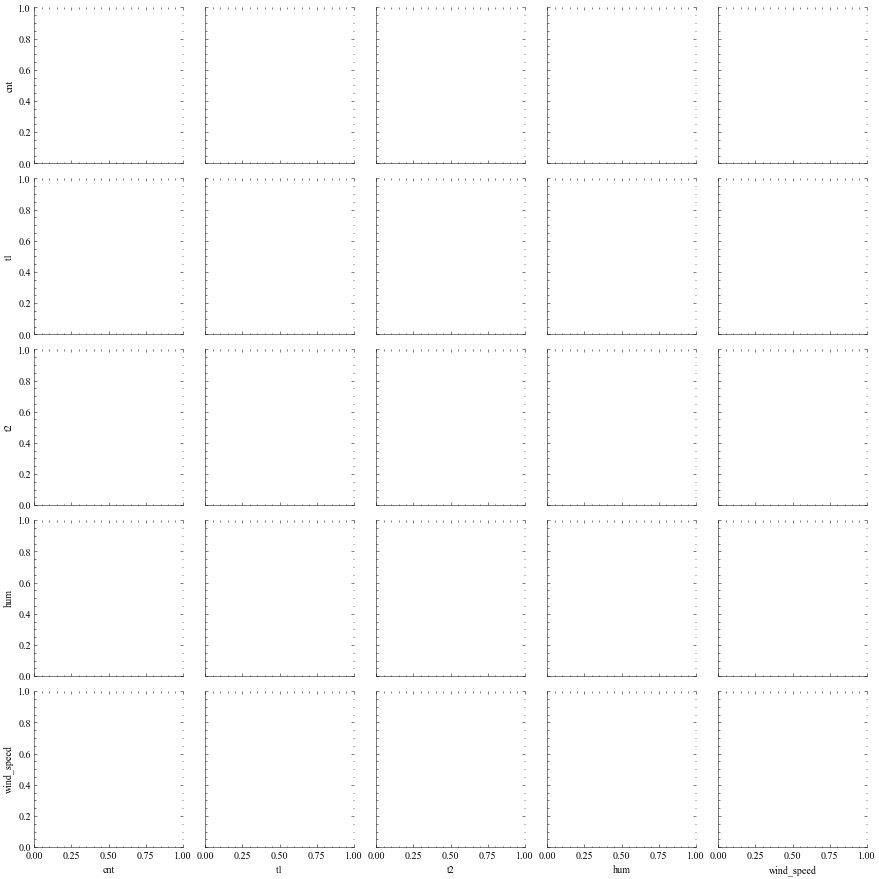

In [182]:
sns.PairGrid(dfx)